In [1]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2
figsize = (10, 10)


In [2]:
#load left and right images
rgb_l = cv2.cvtColor(cv2.imread("dt-left.jpeg"), cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
rgb_r = cv2.cvtColor(cv2.imread("dt-right.jpeg"), cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)



## SIFT feature detection and description


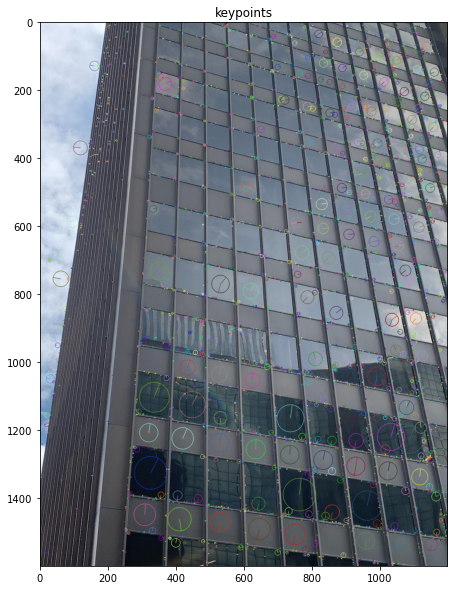

In [3]:
# use orb if sift is not installed
feature_extractor = cv2.SIFT_create()

# find the keypoints and descriptors with chosen feature_extractor
kp_l, desc_l = feature_extractor.detectAndCompute(gray_l, None)
kp_r, desc_r = feature_extractor.detectAndCompute(gray_r, None)

test = cv2.drawKeypoints(rgb_l, kp_l, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=figsize)
plt.imshow(test)
plt.title("keypoints")
plt.show()



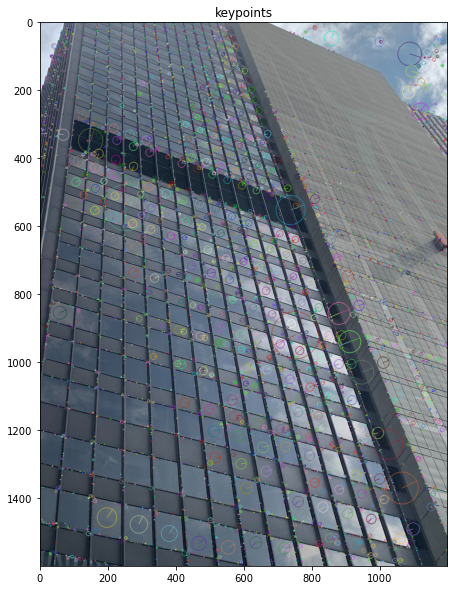

In [4]:
test = cv2.drawKeypoints(rgb_r, kp_r, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=figsize)
plt.imshow(test)
plt.title("keypoints")
plt.show()

## obtain matches between keypoints extracted from left, right images using their descriptors


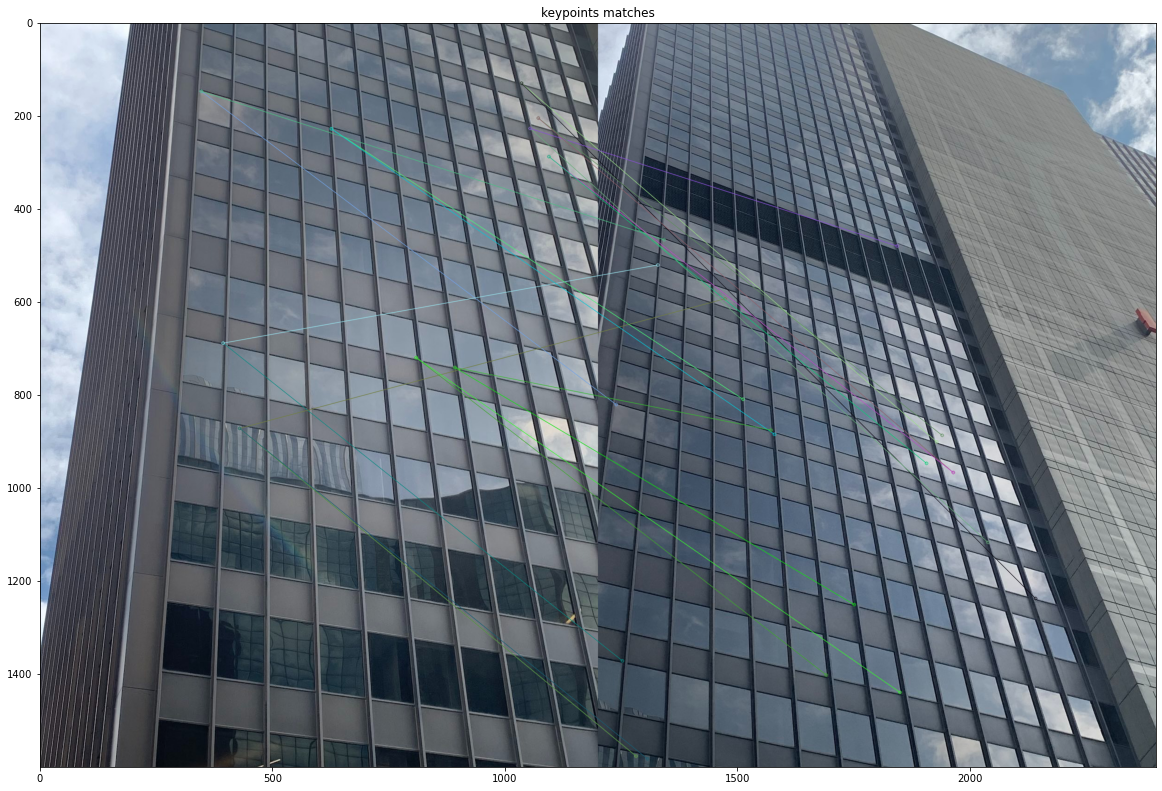

In [5]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_l, desc_r, k=2)

# Apply ratio test
good_and_second_good_match_list = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good_and_second_good_match_list.append([m,n])
good_match_arr = np.asarray(good_and_second_good_match_list)[:,0]

# show only 30 matches
im_matches = cv2.drawMatchesKnn(rgb_l, kp_l, rgb_r, kp_r,
                                good_and_second_good_match_list[0:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 20))
plt.imshow(im_matches)
plt.title("keypoints matches")
plt.show()



## find homography between images


In [6]:
# extract the good/top matched keypoints in left image from good_match_arr using queryidx
good_kp_l = np.array([kp_l[m.queryIdx].pt for m in good_match_arr])

# extract the good/top matched keypoints in right image from good_match_arr using trainidx
good_kp_r = np.array([kp_r[m.trainIdx].pt for m in good_match_arr])

In [7]:
# calculate homography using the matches.

H = np.eye(3,3)

print(H)


[[ 1.10666865e+00  1.26502507e-01  2.44605382e+02]
 [-3.30209030e-02  1.21653687e+00 -8.31222095e+02]
 [-5.78227720e-05  1.57705528e-04  1.00000000e+00]]


## overlay images


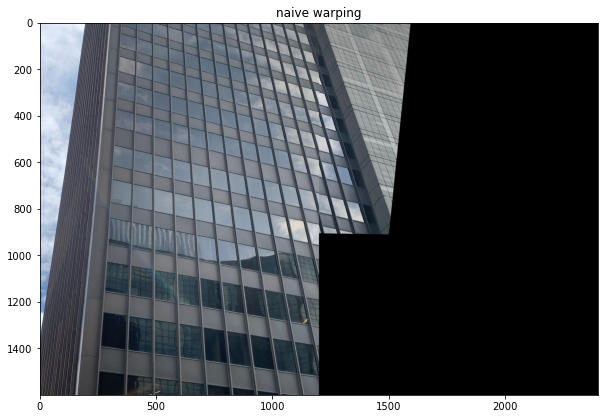

In [8]:
# step 1: warp the right image using H or alternatively left image using inverse(H) with output width as sum of widths of the images
rgb_r_warped = cv2.warpPerspective(rgb_r, H, ( 1200+1200, rgb_l.shape[0]))


# step 2: place the left image in the left half of the output warp in the above output after step 1
rgb_r_warped[0:rgb_l.shape[0], 0:rgb_l.shape[1]] = rgb_l

plt.figure(figsize=figsize)
plt.imshow(rgb_r_warped)
plt.title("naive warping")
plt.show()


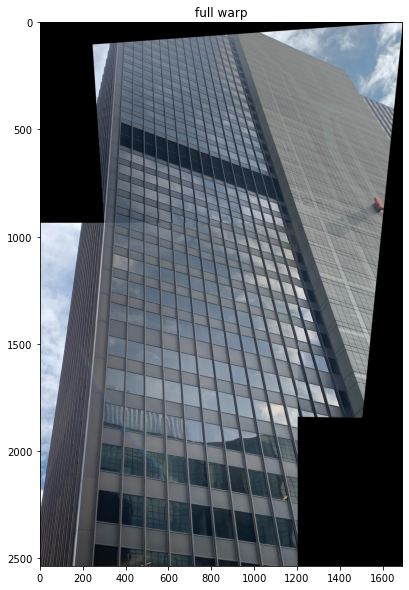

In [9]:


def full_warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H
    '''
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # corners of the images
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

    # find the corners of img2 after transforming them with H
    pts2_ = pts2

    # step 0: find the translation required from the 8 corners i.e., pts1 and pts2_
    
    Ht = np.eye(3,3)  # translation for final perspective transform


    # step 1: warp img2 using composition of H and translation found in step 0 and output size as the total size
    result = cv2.warpPerspective(img2, Ht@H, (100, 100))
    
    # step 2: place img1 in result using the translations in step 0
    result[0:h1, 0:w1] = img1
    
    
    return result


result = full_warpTwoImages(rgb_l, rgb_r, H)

plt.figure(figsize=figsize)
plt.imshow(result)
plt.title("full warp")
plt.show()

